### Predict

Use this notebook to train/test models. Using the node system will automatically allow you to cache the trained model for use in the server. Currently the model nodes are named `train_honest_forward` and `train_ensemble`.

In [11]:
import nodes
import verbose
verbose.set_level( 0 )

#model = nodes.find( "train_honest_forward" ).get_result( subset = slice( 0, 5 ))
model = nodes.find( "train_honest_forward" ).get_result( )

inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1.0/1.0 [00:18<00:00, 18.75s/it]
new_deaths_smoothed_per_million


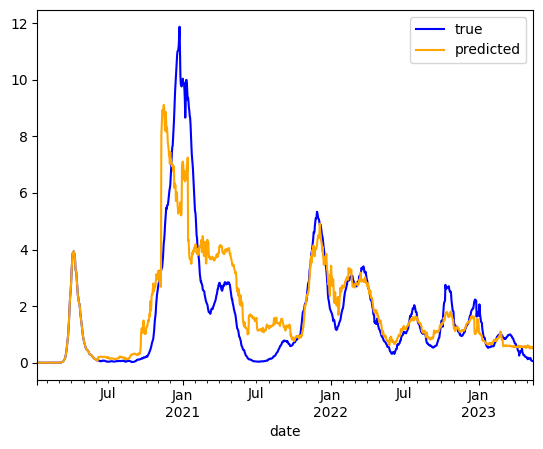

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import require

data_for_country = require.single( "data_for_country" )
crop_to_valid_range = require.single( "crop_to_valid_range" )
df = crop_to_valid_range( data_for_country.get_result( "Germany" ))

time_range = slice( 0, None )
column_name = "new_deaths_smoothed_per_million"
column = df.columns.tolist( ).index( column_name )

start = 138
with tqdm( file = sys.stdout, total = 1.0, desc = "inference" ) as bar:

    df_pred = model.predict_replace( df, start = start, callback = lambda p: bar.update( p - bar.n ))

assert not df.isna( ).any( ).any( )
assert not df_pred.isna( ).any( ).any( )

df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )


line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )
print( df_pred.columns[ column ])